# Install

In [1]:
!pip install pycaret --quiet
!pip install catboost --quiet

# Imports

In [2]:
import numpy as np
import pandas as pd
from pycaret.datasets import get_data
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

# Utils

In [3]:
def get_dataset(dataset_name):
  """Get dataset."""
  target_name = datasets.loc[datasets["Dataset"]==dataset_name, "Target Variable 1"]
  df = get_data(dataset_name, verbose=False).sample(frac=1, replace=False).reset_index(drop=True)
  X, y = df.drop(target_name, axis=1), df[target_name]
  y = y.replace({yval: binval for yval, binval in zip(y.value_counts().index, [0,1])}).iloc[:,0]
  num_features = X.columns[X.apply(is_numeric)].tolist()
  cat_features = [c for c in X.columns if c not in num_features]
  return X, y, num_features, cat_features

def is_numeric(x):
  """Check whether an object is numeric."""
  try:
    x+0
    return True
  except:
    return False

def oos_r2_score(y_true, y_pred, y_dummy_pred):
    """Return out-of-sample R-squared."""
    mse_pred = mean_squared_error(y_true, y_pred)
    mse_dummy = mean_squared_error(y_true, y_dummy_pred)
    oos_r2 = 1 - (mse_pred / mse_dummy)
    return oos_r2

# Load data and train models

In [4]:
datasets = get_data(verbose=False)

X_full, y_full, num_features, cat_features = get_dataset("house")

X, y, pred = {}, {}, {}

model = {
    "CatBoost": CatBoostRegressor(cat_features=cat_features, silent=True),
    "Price Per Square Foot": LinearRegression(),
    "Dummy": DummyRegressor(strategy="mean"),
}

y["train"], y["test"] = train_test_split(y_full[y_full>10_000], train_size=.5, random_state=123)

for s in ["train", "test"]:

    X[s] = {
        "CatBoost": X_full.loc[y[s].index, :].fillna({feature: "NULL" for feature in cat_features}),
        "Price Per Square Foot": X_full.loc[y[s].index, ["GrLivArea"]],
        "Dummy": X_full.loc[y[s].index, ["Id"]],
    }

    if s == "train":
        model = {
            model_name: model[model_name].fit(X["train"][model_name], y["train"])
            for model_name in model.keys()
        }

    pred[s] = {
        model_name: pd.Series(model[model_name].predict(X[s][model_name]), index=y[s].index)
        for model_name in model.keys()
    }

# Compute metrics

In [5]:
segments_dict = {
    "*": ["*"],
    "Neighborhood": ["*"],
}

results = pd.DataFrame(columns = ["sample", "feature", "segment", "n"])
enum = 0

for feature, segments in segments_dict.items():
    if feature != "*" and segments == ["*"]:
        segments = sorted(X[sample]["CatBoost"][feature].unique())
    for segment in segments:
        for sample in y.keys():
            if feature != "*" and sample == "train":
                continue
            ix = X[sample]["CatBoost"].index if feature == "*" else X[sample]["CatBoost"][X[sample]["CatBoost"][feature] == segment].index
            results.loc[enum, ["sample", "feature", "segment", "n"]] = sample, feature, segment, len(ix)
            for metric_name, metric in zip(["R^2", "oos-R^2"], [r2_score, oos_r2_score]):
                for model_name in ["CatBoost", "Price Per Square Foot"]:
                    pred_test_segment = pred[sample][model_name][ix]
                    metric_params = {
                        **{"y_true": y[sample][ix], "y_pred": pred[sample][model_name][ix]},
                        **({"y_dummy_pred": pred[sample]["Dummy"][ix]} if metric == oos_r2_score else {})
                    }
                    results.loc[enum, f"{metric_name}({model_name})"] = metric(**metric_params)
            enum += 1

results_format = results.apply(lambda col: col.apply(lambda x: f"{x:.1%}" if "R^2" in col.name else (f"{x:,.0f}" if is_numeric(x) else x)))

# Display

In [6]:
results_format[results_format["feature"] == "*"]

,sample,feature,segment,n,R^2(CatBoost),R^2(Price Per Square Foot),oos-R^2(CatBoost),oos-R^2(Price Per Square Foot)
0,train,*,*,711,98.6%,47.6%,98.6%,47.6%
1,test,*,*,712,88.3%,53.3%,88.4%,53.4%


In [7]:
temp = results_format.loc[results.query("sample == 'test' and feature == 'Neighborhood' and n > 15").index, ["segment", "R^2(Price Per Square Foot)", "oos-R^2(Price Per Square Foot)"]]
temp.columns = ["neighborhood" if c == "segment" else c for c in temp.columns]
temp

,neighborhood,R^2(Price Per Square Foot),oos-R^2(Price Per Square Foot)
5,BrkSide,51.2%,78.3%
6,ClearCr,-7.2%,20.0%
7,CollgCr,66.3%,68.1%
8,Crawfor,42.4%,46.2%
9,Edwards,-93.0%,22.5%
10,Gilbert,13.5%,19.2%
11,IDOTRR,-162.7%,62.7%
13,Mitchel,18.8%,54.8%
14,NAmes,-25.0%,54.2%
16,NWAmes,28.2%,35.7%


In [8]:
results \
    .query("sample == 'test'") \
    .drop(["sample", "segment"], axis=1) \
    .groupby("feature") \
    .apply(lambda d: d.apply(lambda col: col * d["n"] / d["n"].sum()).sum()).drop("n", axis=1) \
    .applymap(lambda x: f"{x:.1%}") \
    .reset_index()

,feature,R^2(CatBoost),R^2(Price Per Square Foot),oos-R^2(CatBoost),oos-R^2(Price Per Square Foot)
0,*,88.3%,53.3%,88.4%,53.4%
1,Neighborhood,74.0%,-34.7%,86.7%,45.1%


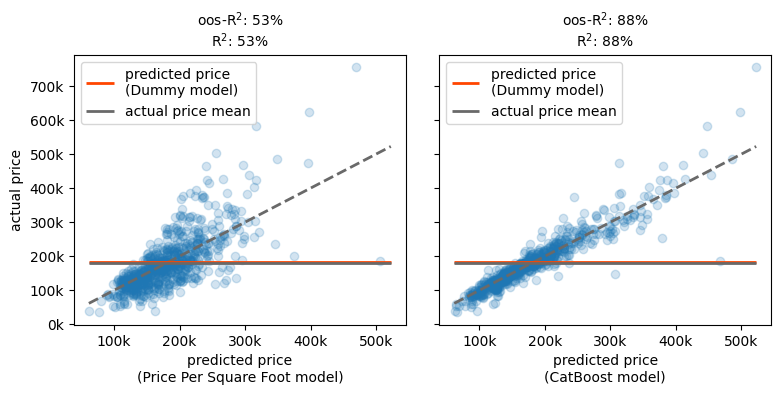

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3.5), sharey=True, sharex=True)
plt.subplots_adjust(wspace=.1)

pred_min = min(pred["test"]["Price Per Square Foot"].min(), pred["test"]["CatBoost"].min())
pred_max = max(pred["test"]["Price Per Square Foot"].max(), pred["test"]["CatBoost"].max())

for col, model_name in enumerate(["Price Per Square Foot", "CatBoost"]):
    r2 = results.query(f"sample == 'test' and feature == '*' and segment == '*'")[f"R^2({model_name})"].iloc[0]
    r2_oos = results.query(f"sample == 'test' and feature == '*' and segment == '*'")[f"oos-R^2({model_name})"].iloc[0]
    ax = axs[col]
    ax.scatter(pred["test"][model_name], y["test"], alpha=.2)
    ax.plot([pred_min, pred_max], [pred_min, pred_max], ls="--", lw=2, color="dimgrey")
    ax.hlines(pred["test"]["Dummy"].iloc[0], pred_min, pred_max, lw=2, label=f"predicted price\n(Dummy model)", color="orangered")
    ax.hlines(y["test"].mean(), pred_min, pred_max, lw=2, color="dimgrey", label=f"actual price mean")
    ax.set_xlabel(f"predicted price\n({model_name} model)")
    ax.set_ylabel("actual price") if col == 0 else None
    ax.set_yticks(ax.get_yticks()[1:-1], [f"{int(y/1000)}k" for y in ax.get_yticks()[1:-1]]) if col == 0 else None
    ax.set_xticks(ax.get_xticks()[1:-1], [f"{int(x/1000)}k" for x in ax.get_xticks()[1:-1]]) if col == 1 else None
    ax.legend()
    ax.set_title(f"oos-R$^2$: {r2_oos:.0%}\nR$^2$: {r2:.0%}", fontsize=10)

fig.savefig("r2_vs_oosr2_all_no_red_line.png", dpi=200, bbox_inches="tight")

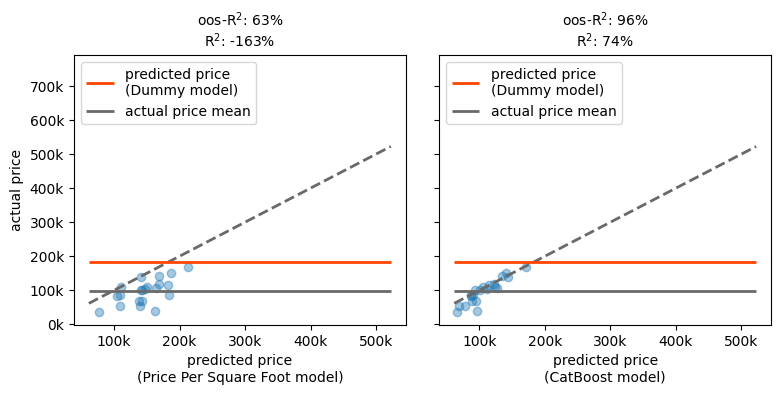

In [10]:
feature = "Neighborhood"
segment = "IDOTRR"

fig, axs = plt.subplots(1, 2, figsize=(9,3.5), sharey=True, sharex=True)
plt.subplots_adjust(wspace=.1)

for col, model_name in enumerate(["Price Per Square Foot", "CatBoost"]):
    r2 = results.query(f"sample == 'test' and feature == '{feature}' and segment == '{segment}'")[f"R^2({model_name})"].iloc[0]
    r2_oos = results.query(f"sample == 'test' and feature == '{feature}' and segment == '{segment}'")[f"oos-R^2({model_name})"].iloc[0]

    ix = X["test"]["CatBoost"][X["test"]["CatBoost"][feature] == segment].index

    ax = axs[col]
    ax.scatter(pred["test"][model_name], y["test"], color="white")
    ax.plot([pred_min, pred_max],[pred_min, pred_max], ls="--", lw=2, color="dimgrey")
    ax.scatter(pred["test"][model_name][ix], y["test"][ix], alpha=.4)
    ax.hlines(pred["test"]["Dummy"].iloc[0], pred_min, pred_max, lw=2, label=f"predicted price\n(Dummy model)", color="orangered")
    ax.hlines(y["test"][ix].mean(), pred_min, pred_max, lw=2, color="dimgrey", label="actual price mean")
    ax.set_title(f"oos-R$^2$: {r2_oos:.0%}\nR$^2$: {r2:.0%}", fontsize=10)
    ax.set_xlabel(f"predicted price\n({model_name} model)")
    ax.set_ylabel("actual price") if col == 0 else None
    ax.set_yticks(ax.get_yticks()[1:-1], [f"{int(y/1000)}k" for y in ax.get_yticks()[1:-1]]) if col == 0 else None
    ax.set_xticks(ax.get_xticks()[1:-1], [f"{int(x/1000)}k" for x in ax.get_xticks()[1:-1]]) if col == 1 else None
    ax.legend()

fig.savefig("r2_vs_oosr2_idotrr_no_red_line.png", dpi=200, bbox_inches="tight")

# Toy example

In [11]:
example_pred = np.array([100_000, 120_000, 140_000, 160_000])
example_y = np.array([110_000, 115_000, 130_000, 190_000])
example_y_mean = np.repeat(np.mean(example_y), len(example_y))

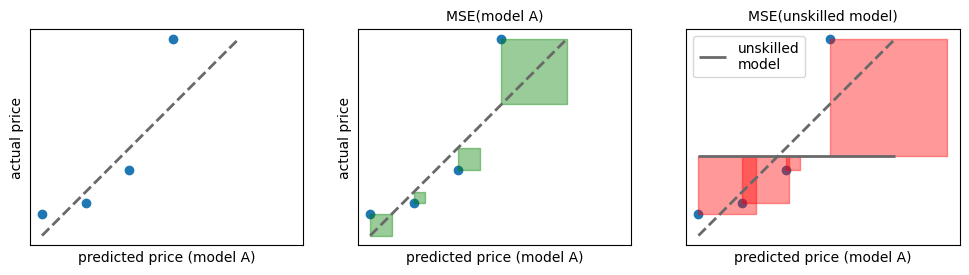

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5), sharex=True, sharey=True)

for i in range(3):
    ax = axs[i]
    ax.scatter(example_pred, example_y)
    ax.plot(
        [np.concatenate([example_pred, example_y]).min(), np.concatenate([example_pred, example_y]).max()],
        [np.concatenate([example_pred, example_y]).min(), np.concatenate([example_pred, example_y]).max()],
        ls="--", lw=2, color="dimgrey")
    ax.set_xlabel("predicted price (model A)")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', adjustable='box')

for i in range(len(example_pred)):
    plot_x = [example_pred[i], example_pred[i] + np.abs(example_pred[i] - example_y[i])]
    axs[1].fill_between(plot_x, example_pred[i], example_y[i], color="green", alpha=.4)
    plot_x = [example_pred[i], example_pred[i] + np.abs(example_y_mean[i] - example_y[i])]
    axs[2].fill_between(plot_x, example_y[i], example_y_mean[i], color="red", alpha=.4)

axs[2].hlines(
    np.mean(example_y), np.concatenate([example_pred, example_y]).min(),
    np.concatenate([example_pred, example_y]).max(), lw=2, color="dimgrey",
    label="unskilled\nmodel")

axs[2].legend(loc="upper left")
axs[1].set_title("MSE(model A)", fontsize=10)
axs[2].set_title("MSE(unskilled model)", fontsize=10)
axs[0].set_ylabel("actual price")
axs[1].set_ylabel("actual price")

fig.savefig("example.png", dpi=200, bbox_inches="tight")

# Latex

In [13]:
%%latex

R^2=1-\frac{\sum_{i}^{}(y_i-pred_i)^2}{\sum_{i}^{}(y_i-\overline{y})^2}

<IPython.core.display.Latex object>

In [14]:
%%latex

oos\textrm{-}R^2=1-\frac{\sum_{i}^{}(y_i-pred_i)^2}{\sum_{i}^{}(y_i-\overline{y}_{train})^2}

<IPython.core.display.Latex object>